In [3]:
# import sys
# import jax
# from numpyro import optim
# jax.config.update('jax_enable_x64', True)  # Use float64
# jax.config.update("jax_default_matmul_precision", "highest")
# # sys.path.append('wishart-process')
# import inference
# import models
# import visualizations
# import evaluation
# import utils

# import jax.numpy as jnp
# import numpyro


import itertools
from tqdm import tqdm
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt

In [14]:
print(np.linspace(0, 12 - 1, 12))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


# import data

In [6]:
#import data

import matplotlib.pyplot as plt
SATED_DECONV = np.load('../Data/predictions_fullTrace_sated.npy', allow_pickle=True)
ANG_STIM_DATA = loadmat('../Data/metadata_deconv/stimAngle_sated.mat', simplify_cells=True)
SF_STIM_DATA  = loadmat('../Data/metadata_deconv/stimSpatFreq_sated.mat', simplify_cells=True)
SATED_ANGLE = ANG_STIM_DATA['order_of_stim_arossAnimals']
SATED_SF    = SF_STIM_DATA['stimSpatFreq_arossAnimals']

FOOD_RESTRICTED_SATED = [1,2,3,6,7,8,11,12]
CONTROL_SATED         = [0,4,5,9,10,13]

def resort_preprocessing(datum,angle_arr,sf_arr,animal):
    data = np.copy(datum[animal,:])
    neurons = data[0].shape[0]
    reshape_data = np.full((60,neurons,data[0].shape[1]), np.nan)
    for i in range(60):
        reshape_data[i,:,:] = data[i]

    reshape_data = reshape_data.reshape(60,neurons,12,120)
    reshape_data = np.transpose(reshape_data,(1,2,0,3))
    #Remove first two neurons
    reshape_data = reshape_data[2:,:,:,:]

    #Remove None trials
    max_trial = np.argmax(np.isnan(reshape_data[0,1,:,0]))
    reshape_data = reshape_data[:,:,:max_trial,:]

    # Remove beginning and last bit # HMMMM should I do this?
    # reshape_data[:,0,:,:32] = np.nan
    # reshape_data[:,-1,:,88:] = np.nan
    # print(np.any(np.isnan(reshape_data)))
    # print(reshape_data.shape)
    
    # Reorder angles
    angles = np.copy(angle_arr[animal])
    for itrials in range(angles.shape[1]):
        order = angles[:,itrials]-1
        reshape_data[:,:,itrials,:] = reshape_data[:,order,itrials,:]

    # Reorder SFs
    reshaped_data = []
    sfs = np.copy(sf_arr[animal])
    for experiment in range(1,6):
        mask = sfs == experiment
        reshaped_data.append(reshape_data[:,:,mask,:])

    max_trials = max([exp.shape[2] for exp in reshaped_data])
    # Pad the data for experiments with (10, 12, 80)fewer trials
    for i in range(len(reshaped_data)):
        if reshaped_data[i].shape[2] < max_trials:
            padding = max_trials - reshaped_data[i].shape[2]
            reshaped_data[i] = np.pad(reshaped_data[i], ((0, 0),(0, 0),(0, padding),(0, 0)), mode='constant', constant_values=np.nan)

    reshaped_data = np.stack(reshaped_data,axis=2)    

    return reshaped_data
x = resort_preprocessing(SATED_DECONV,SATED_ANGLE,SATED_SF,0)
print(np.sum(np.isnan(x)))




def remove_neurons(datum, angles,sfs, animal, count = False):
    neurons_to_keep = []
    data = resort_preprocessing(datum,angles,sfs,animal)
    number_neurons = data.shape[0]    
    for i in range(number_neurons):
        # print(np.nanmean(data[i, :, :, :, 40:80], axis = 3))
        stim_average = np.mean(data[i, :, :, :, 40:80], axis = 3) # OKAY TO NOT HAVE NANMEAN?
        best_sf = np.argmax(np.nanmean(stim_average, axis = (0,2))).astype('int')
        best_angle = np.argmax(np.nanmean(stim_average[:,best_sf,:], axis = 1)).astype('int')
        averaged_calcium = np.nanmean(stim_average[best_angle,best_sf,:])
        
        grey_data = data[i, :, :, :, 0:20]
        # grey_data = np.concatenate((data[i, :, :, :, 0:40], data[i, :, :, :, 80:]), axis = 3)
        grey_average = np.mean(grey_data, axis = 3)
        best_sf = np.argmax(np.nanmean(grey_average, axis = (0,2))).astype(int)
        best_angle = np.argmax(np.nanmean(grey_average[:,best_sf,:], axis = 1)).astype(int)
        average_grey = np.nanmean(grey_average[best_angle,best_sf,:])
        std_grey = np.nanstd(grey_average[best_angle,best_sf,:])
        
        if np.abs(averaged_calcium - average_grey) >= 1.69*std_grey:
            neurons_to_keep.append(i)
    
    # Keep only the neurons that meet the condition
    data_filtered = data[neurons_to_keep, :, :,:,:]
    if count:
        return data_filtered.shape[0]/data.shape[0]

    return data_filtered



670752


In [7]:
TEST_DATA = resort_preprocessing(SATED_DECONV,SATED_ANGLE,SATED_SF,0)[:,:,0,:,40:80]
# Animal = 0, SF = 0 and during response
TEST_RESPONSE = jnp.nanmean(TEST_DATA,axis = -1) # Shape N x C x K 
TEST_RESPONSE = jnp.transpose(TEST_RESPONSE, (2,1,0)) # Shape K X C X N
print(TEST_RESPONSE.shape)
N = TEST_RESPONSE.shape[2]
C = TEST_RESPONSE.shape[1]
K = TEST_RESPONSE.shape[0]
SEED = 1
PERIOD = C
X_CONDITIONS = jnp.linspace(0,C-1,C)

# keep only trials that have at least one finite value
good_trials = ~jnp.isnan(TEST_RESPONSE).all(axis=(1, 2))   # shape (K,)
TEST_RESPONSE = TEST_RESPONSE[good_trials]                 # (K′, C, N)
K = TEST_RESPONSE.shape[0]
print(f"{K} good trials remain")


# Z-score test response along the trial axis
# TEST_RESPONSE = (TEST_RESPONSE - jnp.nanmean(TEST_RESPONSE, axis=0)) / jnp.nanstd(TEST_RESPONSE, axis=0)


NameError: name 'jnp' is not defined

# Compare to Empirical

(12, 128)


/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


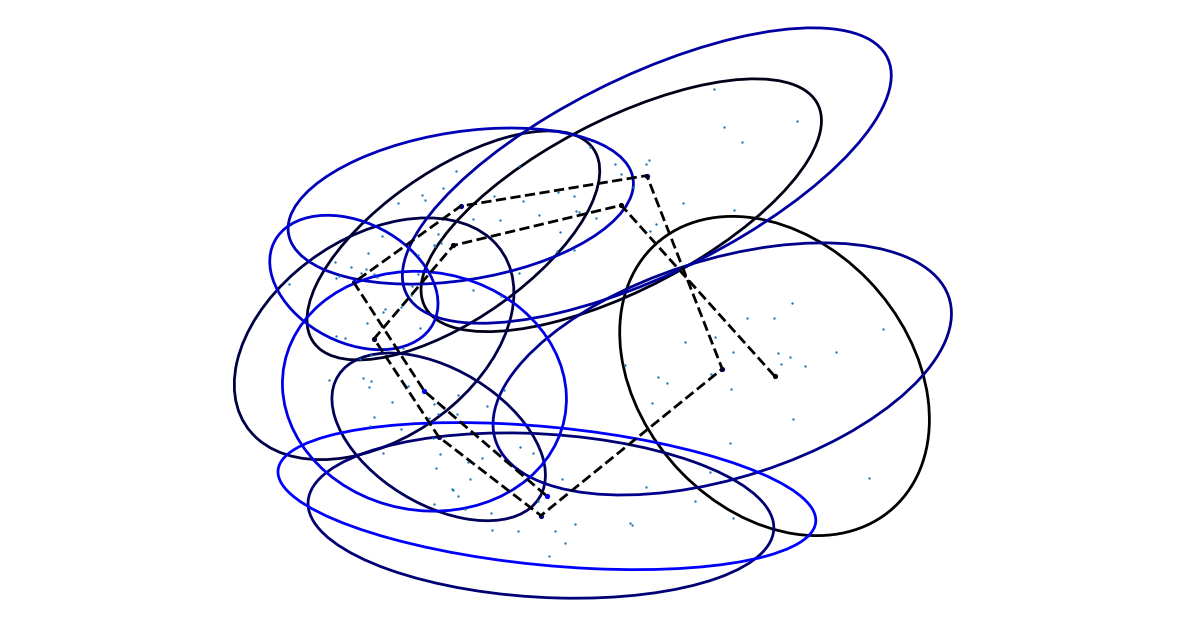

In [17]:
import pandas as pd
empirical_mu = jnp.nanmean(TEST_RESPONSE,axis=0)
print(empirical_mu.shape)
# empirical_cov =jnp.cov(TEST_RESPONSE,axis=0)
empirical_sigma = jnp.zeros((C, N, N))
for i in range(C):
    dat = TEST_RESPONSE[:,i,:] # Shape K x N
    df = pd.DataFrame(dat)
    covariances = df.cov().to_numpy()
    covariances += np.eye(N) * 1e-6
    empirical_sigma = empirical_sigma.at[i].set(covariances)
visualizations.visualize_pc(
    empirical_mu[:,None],empirical_sigma,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
)


## SNR Overall Bar

(12, 5, 162) (12, 5, 162) (48, 5, 162) (48, 5, 162)
(12, 5, 106) (12, 5, 106) (48, 5, 106) (48, 5, 106)
(12, 5, 114) (12, 5, 114) (48, 5, 114) (48, 5, 114)
(12, 5, 136) (12, 5, 136) (48, 5, 136) (48, 5, 136)
(12, 5, 104) (12, 5, 104) (48, 5, 104) (48, 5, 104)
(12, 5, 109) (12, 5, 109) (48, 5, 109) (48, 5, 109)
(12, 5, 235) (12, 5, 235) (48, 5, 235) (48, 5, 235)
(12, 5, 129) (12, 5, 129) (48, 5, 129) (48, 5, 129)
(12, 5, 137) (12, 5, 137) (48, 5, 137) (48, 5, 137)
(12, 5, 112) (12, 5, 112) (48, 5, 112) (48, 5, 112)
(12, 5, 56) (12, 5, 56) (48, 5, 56) (48, 5, 56)
(12, 5, 94) (12, 5, 94) (48, 5, 94) (48, 5, 94)
(12, 5, 104) (12, 5, 104) (48, 5, 104) (48, 5, 104)
(12, 5, 134) (12, 5, 134) (48, 5, 134) (48, 5, 134)


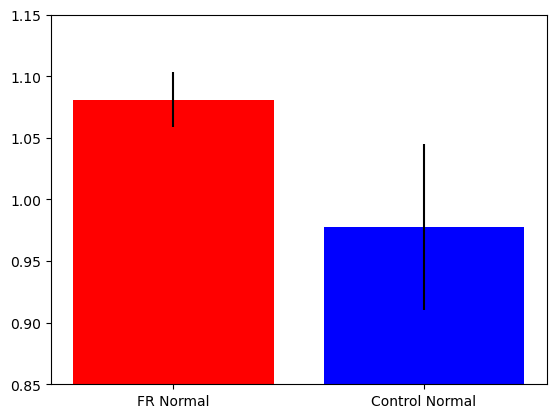

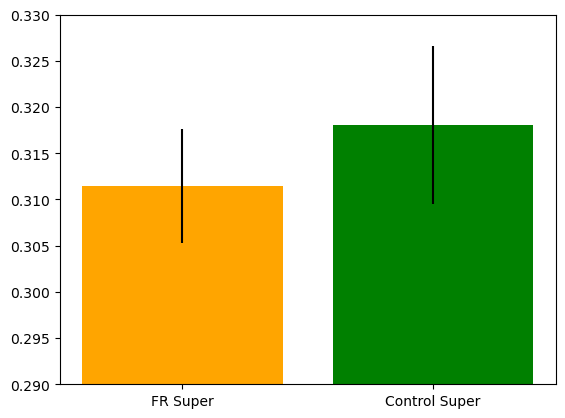

In [6]:
import numpy as np
from types import SimpleNamespace

rag_fr = np.load('../Data/overlaps_sated_fr_ragged_2.npz', allow_pickle=True)
overlaps_normal_dict_fr = rag_fr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_fr = rag_fr['eigs_normal'].item()  # dict[str->ndarray]

overlaps_super_dict_fr = rag_fr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_fr = rag_fr['eigs_super'].item()  # dict[str->ndarray]


rag_ctr = np.load('../Data/overlaps_sated_ctr_ragged_2.npz', allow_pickle=True)
overlaps_normal_dict_ctr = rag_ctr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_ctr = rag_ctr['eigs_normal'].item()
overlaps_super_dict_ctr = rag_ctr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_ctr = rag_ctr['eigs_super'].item()  # dict[str



FOOD_RESTRICTED_SATED = [1,2,3,6,7,8,11,12]
CONTROL_SATED         = [0,4,5,9,10,13]

import matplotlib.pyplot as plt

average_fr_normal = []
average_fr_super = []
for animal in FOOD_RESTRICTED_SATED:
    normal_overlaps = overlaps_normal_dict_fr[animal]
    normal_eigs = eigs_normal_dict_fr[animal]
    super_overlaps = overlaps_super_dict_fr[animal]
    super_eigs = eigs_super_dict_fr[animal]
    snr = normal_overlaps/normal_eigs
    snr_super = super_overlaps/super_eigs
    mean_snr = np.nanmean(snr, axis=(0,1))
    mean_snr_super = np.nanmean(snr_super, axis=(0,1))

    average_fr_normal.append(np.nanmean(mean_snr))
    average_fr_super.append(np.nanmean(mean_snr_super))
    print(normal_overlaps.shape, normal_eigs.shape, super_overlaps.shape, super_eigs.shape)

average_ctr_normal = []
average_ctr_super = []
for animal in CONTROL_SATED:
    normal_overlaps = overlaps_normal_dict_ctr[animal]
    normal_eigs = eigs_normal_dict_ctr[animal]
    super_overlaps = overlaps_super_dict_ctr[animal]
    super_eigs = eigs_super_dict_ctr[animal]
    snr = normal_overlaps/normal_eigs
    snr_super = super_overlaps/super_eigs
    mean_snr = np.nanmean(snr, axis=(0,1))
    mean_snr_super = np.nanmean(snr_super, axis=(0,1))

    average_ctr_normal.append(np.nanmean(mean_snr))
    average_ctr_super.append(np.nanmean(mean_snr_super))
    print(normal_overlaps.shape, normal_eigs.shape, super_overlaps.shape, super_eigs.shape)
plt.bar([0,1], [np.mean(average_fr_normal), np.mean(average_ctr_normal)], yerr=[np.std(average_fr_normal)/np.sqrt(len(average_fr_normal)), np.std(average_ctr_normal)/np.sqrt(len(average_ctr_normal))], tick_label=['FR Normal', 'Control Normal'], color=['red', 'blue']  )
plt.ylim(0.85,1.15)
plt.show()
plt.bar([0,1], [np.mean(average_fr_super), np.mean(average_ctr_super)], yerr=[np.std(average_fr_super)/np.sqrt(len(average_fr_super)), np.std(average_ctr_super)/np.sqrt(len(average_ctr_super))], tick_label=['FR Super', 'Control Super'], color=['orange', 'green']  )
plt.ylim(0.29,0.33)
plt.show()


# Check

FR Normal: n=8, mean=1.081, SEM=0.02383
  Top variance contributor: idx=0, value=1.22
  Contribution to variance: 60.6%
  SEM if dropped: 0.01526  (change: +36.0%)
  ↳ Error likely dominated by a single value.
Control Normal: n=6, mean=0.9774, SEM=0.07394
  Top variance contributor: idx=0, value=1.302
  Contribution to variance: 64.2%
  SEM if dropped: 0.04336  (change: +41.4%)
  ↳ Error likely dominated by a single value.
FR Super: n=8, mean=0.3115, SEM=0.006585
  Top variance contributor: idx=4, value=0.3536
  Contribution to variance: 73.1%
  SEM if dropped: 0.003079  (change: +53.2%)
  ↳ Error likely dominated by a single value.
Control Super: n=6, mean=0.3181, SEM=0.009346
  Top variance contributor: idx=5, value=0.274
  Contribution to variance: 74.0%
  SEM if dropped: 0.003834  (change: +59.0%)
  ↳ Error likely dominated by a single value.


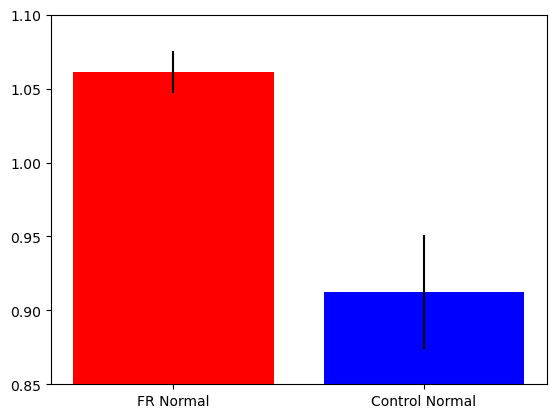

(0.29, 0.34)

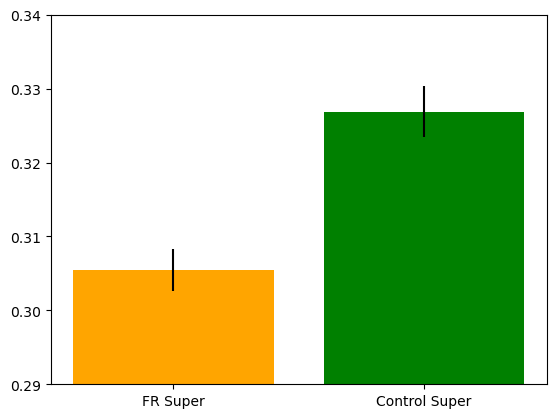

In [7]:
def sem_influence(x, name="group"):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0:
        print(f"{name}: empty array"); 
        return

    mu = x.mean()
    sd = x.std(ddof=1) if n > 1 else 0.0
    sem = sd / np.sqrt(n) if n > 1 else 0.0

    # Variance contribution of each point
    r2 = (x - mu)**2
    total_ss = r2.sum()
    contrib = r2 / total_ss if total_ss > 0 else np.zeros_like(x)

    # Leave-one-out SEM (undefined for n<3)
    if n >= 3:
        loo_sem = np.array([
            np.std(np.delete(x, i), ddof=1) / np.sqrt(n - 1) for i in range(n)
        ])
        # How much SEM drops if we remove point i (positive = this point inflates SEM)
        sem_drop = sem - loo_sem
    else:
        loo_sem = np.full(n, np.nan)
        sem_drop = np.full(n, np.nan)

    # Report top influencer
    i_top = int(np.nanargmax(contrib))
    dominance = contrib[i_top]
    drop_pct = (sem_drop[i_top] / sem) * 100 if sem > 0 and np.isfinite(sem_drop[i_top]) else np.nan

    print(f"{name}: n={n}, mean={mu:.4g}, SEM={sem:.4g}")
    print(f"  Top variance contributor: idx={i_top}, value={x[i_top]:.4g}")
    print(f"  Contribution to variance: {dominance*100:.1f}%")
    if np.isfinite(drop_pct):
        print(f"  SEM if dropped: {loo_sem[i_top]:.4g}  (change: {drop_pct:+.1f}%)")

    # Optional: simple dominance flags
    dominated = (dominance > 0.5) or (np.isfinite(drop_pct) and drop_pct > 30)
    if dominated:
        print("  ↳ Error likely dominated by a single value.")
    else:
        print("  ↳ No single value appears to dominate.")
    
    #return index of top influencer
    return i_top

# Use on your data:
itop_fr_n = sem_influence(average_fr_normal,   "FR Normal")
itop_ctr_n = sem_influence(average_ctr_normal,  "Control Normal")
itop_fr_s = sem_influence(average_fr_super,    "FR Super")
itop_ctr_s = sem_influence(average_ctr_super,   "Control Super")


dropped_fr_normal = [x for i,x in enumerate(average_fr_normal) if i!=itop_fr_n]
dropped_ctr_normal = [x for i,x in enumerate(average_ctr_normal) if i!=itop_ctr_n]
dropped_fr_super = [x for i,x in enumerate(average_fr_super) if i!=itop_fr_s]
dropped_ctr_super = [x for i,x in enumerate(average_ctr_super) if i!=itop_ctr_s]
plt.bar([0,1], [np.mean(dropped_fr_normal), np.mean(dropped_ctr_normal)], yerr=[np.std(dropped_fr_normal)/np.sqrt(len(dropped_fr_normal)), np.std(dropped_ctr_normal)/np.sqrt(len(dropped_ctr_normal))], tick_label=['FR Normal', 'Control Normal'], color=['red', 'blue']  )
plt.ylim(0.85,1.10)
plt.show()
plt.bar([0,1], [np.mean(dropped_fr_super), np.mean(dropped_ctr_super)], yerr=[np.std(dropped_fr_super)/np.sqrt(len(dropped_fr_super)), np.std(dropped_ctr_super)/np.sqrt(len(dropped_ctr_super))], tick_label=['FR Super', 'Control Super'], color=['orange', 'green']  )
plt.ylim(0.29,0.34)

## Early vs Late SNR barchart

(12, 5, 162) (12, 5, 162) (48, 5, 162) (48, 5, 162)
(12, 5, 106) (12, 5, 106) (48, 5, 106) (48, 5, 106)
(12, 5, 114) (12, 5, 114) (48, 5, 114) (48, 5, 114)
(12, 5, 136) (12, 5, 136) (48, 5, 136) (48, 5, 136)
(12, 5, 104) (12, 5, 104) (48, 5, 104) (48, 5, 104)
(12, 5, 109) (12, 5, 109) (48, 5, 109) (48, 5, 109)
(12, 5, 235) (12, 5, 235) (48, 5, 235) (48, 5, 235)
(12, 5, 129) (12, 5, 129) (48, 5, 129) (48, 5, 129)
(12, 5, 137) (12, 5, 137) (48, 5, 137) (48, 5, 137)
(12, 5, 112) (12, 5, 112) (48, 5, 112) (48, 5, 112)
(12, 5, 56) (12, 5, 56) (48, 5, 56) (48, 5, 56)
(12, 5, 94) (12, 5, 94) (48, 5, 94) (48, 5, 94)
(12, 5, 104) (12, 5, 104) (48, 5, 104) (48, 5, 104)
(12, 5, 134) (12, 5, 134) (48, 5, 134) (48, 5, 134)


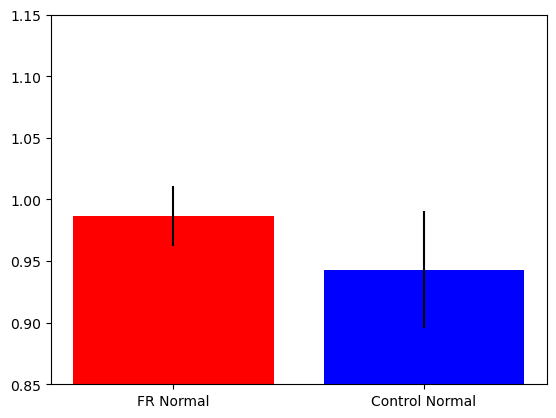

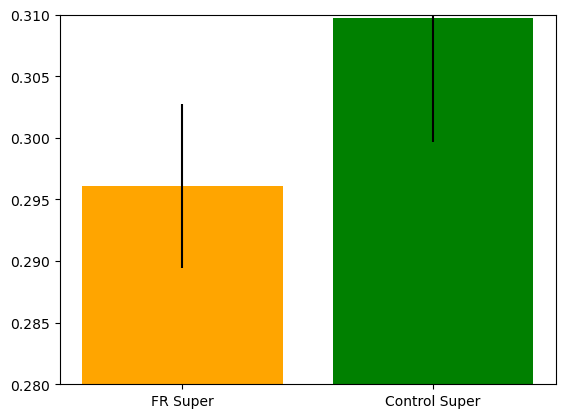

In [14]:
import numpy as np
from types import SimpleNamespace

rag_fr = np.load('../Data/overlaps_sated_fr_ragged_3_late.npz', allow_pickle=True)
overlaps_normal_dict_fr = rag_fr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_fr = rag_fr['eigs_normal'].item()  # dict[str->ndarray]

overlaps_super_dict_fr = rag_fr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_fr = rag_fr['eigs_super'].item()  # dict[str->ndarray]


rag_ctr = np.load('../Data/overlaps_sated_ctr_ragged_3_late.npz', allow_pickle=True)
overlaps_normal_dict_ctr = rag_ctr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_ctr = rag_ctr['eigs_normal'].item()
overlaps_super_dict_ctr = rag_ctr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_ctr = rag_ctr['eigs_super'].item()  # dict[str



FOOD_RESTRICTED_SATED = [1,2,3,6,7,8,11,12]
CONTROL_SATED         = [0,4,5,9,10,13]

import matplotlib.pyplot as plt

average_fr_normal = []
average_fr_super = []
for animal in FOOD_RESTRICTED_SATED:
    normal_overlaps = overlaps_normal_dict_fr[animal]
    normal_eigs = eigs_normal_dict_fr[animal]
    super_overlaps = overlaps_super_dict_fr[animal]
    super_eigs = eigs_super_dict_fr[animal]
    snr = normal_overlaps/normal_eigs
    snr_super = super_overlaps/super_eigs
    mean_snr = np.nanmean(snr, axis=(0,1))
    mean_snr_super = np.nanmean(snr_super, axis=(0,1))

    average_fr_normal.append(np.nanmean(mean_snr))
    average_fr_super.append(np.nanmean(mean_snr_super))
    print(normal_overlaps.shape, normal_eigs.shape, super_overlaps.shape, super_eigs.shape)

average_ctr_normal = []
average_ctr_super = []
for animal in CONTROL_SATED:
    normal_overlaps = overlaps_normal_dict_ctr[animal]
    normal_eigs = eigs_normal_dict_ctr[animal]
    super_overlaps = overlaps_super_dict_ctr[animal]
    super_eigs = eigs_super_dict_ctr[animal]
    snr = normal_overlaps/normal_eigs
    snr_super = super_overlaps/super_eigs
    mean_snr = np.nanmean(snr, axis=(0,1))
    mean_snr_super = np.nanmean(snr_super, axis=(0,1))

    average_ctr_normal.append(np.nanmean(mean_snr))
    average_ctr_super.append(np.nanmean(mean_snr_super))
    print(normal_overlaps.shape, normal_eigs.shape, super_overlaps.shape, super_eigs.shape)
plt.bar([0,1], [np.mean(average_fr_normal), np.mean(average_ctr_normal)], yerr=[np.std(average_fr_normal)/np.sqrt(len(average_fr_normal)), np.std(average_ctr_normal)/np.sqrt(len(average_ctr_normal))], tick_label=['FR Normal', 'Control Normal'], color=['red', 'blue']  )
plt.ylim(0.85,1.15)
plt.show()
plt.bar([0,1], [np.mean(average_fr_super), np.mean(average_ctr_super)], yerr=[np.std(average_fr_super)/np.sqrt(len(average_fr_super)), np.std(average_ctr_super)/np.sqrt(len(average_ctr_super))], tick_label=['FR Super', 'Control Super'], color=['orange', 'green']  )
plt.ylim(0.28,0.31)
plt.show()


FR Normal: n=8, mean=0.9867, SEM=0.02597
  Top variance contributor: idx=0, value=1.12
  Contribution to variance: 47.2%
  SEM if dropped: 0.02035  (change: +21.7%)
  ↳ No single value appears to dominate.
Control Normal: n=6, mean=0.9431, SEM=0.05195
  Top variance contributor: idx=0, value=1.147
  Contribution to variance: 51.2%
  SEM if dropped: 0.03949  (change: +24.0%)
  ↳ Error likely dominated by a single value.
FR Super: n=8, mean=0.2961, SEM=0.007136
  Top variance contributor: idx=4, value=0.342
  Contribution to variance: 73.9%
  SEM if dropped: 0.003253  (change: +54.4%)
  ↳ Error likely dominated by a single value.
Control Super: n=6, mean=0.3097, SEM=0.01105
  Top variance contributor: idx=5, value=0.257
  Contribution to variance: 75.9%
  SEM if dropped: 0.004044  (change: +63.4%)
  ↳ Error likely dominated by a single value.


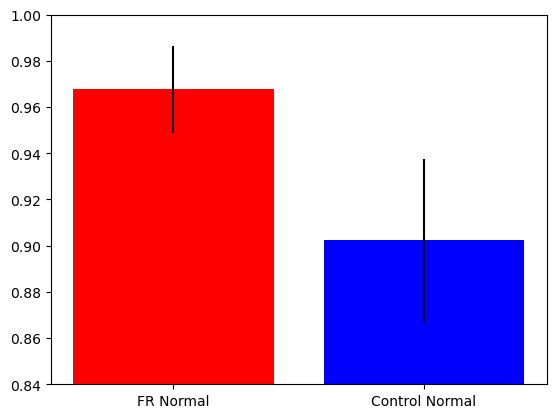

(0.28, 0.35)

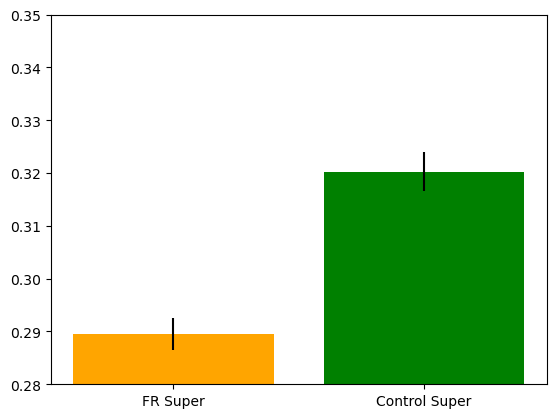

In [15]:
itop_fr_n = sem_influence(average_fr_normal,   "FR Normal")
itop_ctr_n = sem_influence(average_ctr_normal,  "Control Normal")
itop_fr_s = sem_influence(average_fr_super,    "FR Super")
itop_ctr_s = sem_influence(average_ctr_super,   "Control Super")


dropped_fr_normal = [x for i,x in enumerate(average_fr_normal) if i!=itop_fr_n]
dropped_ctr_normal = [x for i,x in enumerate(average_ctr_normal) if i!=itop_ctr_n]
dropped_fr_super = [x for i,x in enumerate(average_fr_super) if i!=itop_fr_s]
dropped_ctr_super = [x for i,x in enumerate(average_ctr_super) if i!=itop_ctr_s]
plt.bar([0,1], [np.mean(dropped_fr_normal), np.mean(dropped_ctr_normal)], yerr=[np.std(dropped_fr_normal)/np.sqrt(len(dropped_fr_normal)), np.std(dropped_ctr_normal)/np.sqrt(len(dropped_ctr_normal))], tick_label=['FR Normal', 'Control Normal'], color=['red', 'blue']  )
plt.ylim(0.84,1)
plt.show()
plt.bar([0,1], [np.mean(dropped_fr_super), np.mean(dropped_ctr_super)], yerr=[np.std(dropped_fr_super)/np.sqrt(len(dropped_fr_super)), np.std(dropped_ctr_super)/np.sqrt(len(dropped_ctr_super))], tick_label=['FR Super', 'Control Super'], color=['orange', 'green']  )
plt.ylim(0.28,0.35)

# New Analysis

In [1]:
import pickle
from pathlib import Path
from scipy import stats 
def load_overlap_eigs(save_dir, group_prefix, animal, sf):
    """
    group_prefix: 'FR' or 'CTR' (or whatever you used as fname_prefix)
    sf: int or None
    """
    sf_tag = "best_sf" if sf is None else f"sf{int(sf)}"
    p = Path(save_dir) / f"{group_prefix}_{animal}_{sf_tag}_overlaps_eigs.pkl"
    with open(p, "rb") as f:
        return pickle.load(f)


folder_name = "saved_overlap_eigs_normal_0210_fixed"
# folder_name = "saved_overlap_eigs_normal_2509_smaller"
# folder_name = "saved_overlap_eigs_normal_2509_smaller_sf_sum"
# folder_name = "saved_overlap_eigs_normal_2509_smaller_sf_sum_remove"



In [5]:
# Example:
datatemp = load_overlap_eigs(folder_name, "FR", f"{1}", sf=0)
conditions_saved = datatemp["array_conditions"]
fr_raw =  np.full((8,5,len(conditions_saved)),np.nan)
ctr_raw =  np.full((8,5,len(conditions_saved)),np.nan)
number_neurons = 80
sum_snr_value_fr = np.full((8,5,len(conditions_saved)),np.nan)
for animal_number in range(1,9):
    for sf in range(5):
        try:
            data = load_overlap_eigs(folder_name, "FR", f"{animal_number}", sf=sf)
            overlaps_list = data["overlaps_per_condition"]  # list of arrays
            eigs_list = data["eigs_per_condition"]          # list of arrays
            for conds in range(len(overlaps_list)):
                fr_raw[animal_number-1, sf, conds] = np.nanmean(np.sum(overlaps_list[conds], axis=1))  # mean over angles, sum over modes

                # random_sample_80_neurons = np.random.choice(overlaps_list[conds].shape[1], size=number_neurons, replace=False)
                
                snr_list = overlaps_list[conds] / eigs_list[conds]

                mean_snr = np.nansum(snr_list, axis=(1))
                # random_sample_80_neurons_snr = mean_snr[random_sample_80_neurons]
                total_snr = np.nanmean(mean_snr)
                sum_snr_value_fr[animal_number-1, sf, conds] = total_snr
        except Exception as e:
            continue


sum_snr_value_ctr = np.full((6,5,len(conditions_saved)),np.nan)
for animal_number in range(1,7):
    for sf in range(5):
        try:
            data = load_overlap_eigs(folder_name, "CTR", f"{animal_number}", sf=sf)
            overlaps_list = data["overlaps_per_condition"]  # list of arrays
            eigs_list = data["eigs_per_condition"]          # list of arrays
            for conds in range(len(overlaps_list)):
                ctr_raw[animal_number-1, sf, conds] = np.nanmean(np.sum(overlaps_list[conds], axis=1))  # mean over angles, sum over modes
                # random_sample_80_neurons = np.random.choice(overlaps_list[conds].shape[1], size=number_neurons, replace=False)
                snr_list = overlaps_list[conds] / eigs_list[conds]
                mean_snr = np.nansum(snr_list, axis=(1))
                # random_sample_80_neurons_snr = mean_snr[random_sample_80_neurons]
                total_snr = np.nanmean(mean_snr)
                sum_snr_value_ctr[animal_number-1, sf, conds] = total_snr
        except Exception as e:
            continue

snr_fr = np.nanmean(sum_snr_value_fr, axis=(0,1))
snr_ctr = np.nanmean(sum_snr_value_ctr, axis=(0,1))
performance_fr = stats.norm.cdf(np.sqrt(snr_fr)/2)
performance_ctr = stats.norm.cdf(np.sqrt(snr_ctr)/2)

plt.figure()
plt.plot(360/np.array(conditions_saved), performance_fr, color='red', marker='o', linestyle='-', label='FR')
plt.plot(360/np.array(conditions_saved), performance_ctr, color='blue', marker='o', linestyle='-', label='Control')
plt.legend()
plt.xlabel('Angle difference (degrees)')
plt.ylabel('Performance (80 random neurons)')
plt.xlim(0,40)

FileNotFoundError: [Errno 2] No such file or directory: 'saved_overlap_eigs_normal_0210/FR_1_sf0_overlaps_eigs.pkl'

/tmp/ipykernel_585067/462029565.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0, 0.5, 'Performance ')

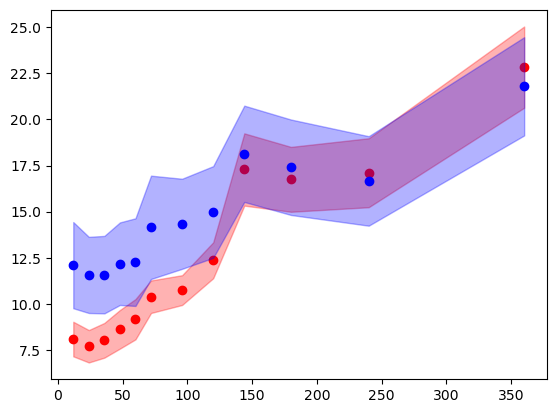

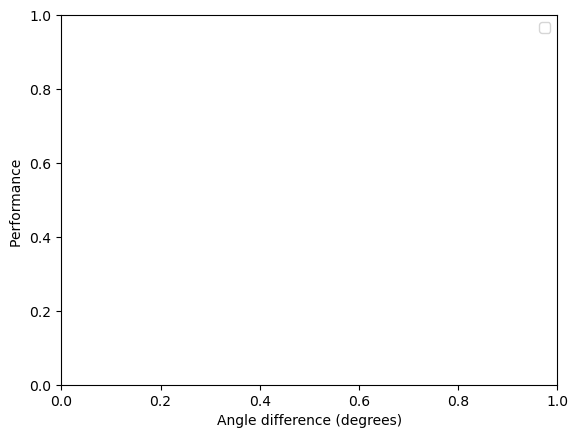

In [10]:
#FOR BEST SFS  !!
####
####
####
# conditions_array = [8, 12, 18, 24, 36, 45, 48,60, 72, 120, 180, 360, 720, 1440]
conditions_saved = [12, 24, 36, 48, 60, 72, 96, 120, 144, 180, 240, 360]

fr_raw =  np.full((8,len(conditions_saved)),np.nan)
ctr_raw =  np.full((8,len(conditions_saved)),np.nan)
sum_snr_value_fr = np.full((8,len(conditions_saved)),np.nan)
for idx, animal_number in enumerate(FOOD_RESTRICTED_SATED):
    try:
        data = load_overlap_eigs(folder_name, "FR", f"{animal_number}", sf=None)
        # overlaps_list = data["overlaps_per_condition"]  # list of arrays
        # eigs_list = data["eigs_per_condition"]          # list of arrays
        # for conds in range(len(overlaps_list)):
        #     fr_raw[animal_number-1, conds] = np.nanmean(np.sum(overlaps_list[conds], axis=1))  # mean over angles, sum over modes            
        #     snr_list = overlaps_list[conds] / eigs_list[conds]

        #     total_snr = np.nansum(snr_list, axis=(1))
        #     mean_snr = np.nanmean(total_snr)
        #     sum_snr_value_fr[animal_number-1, conds] = mean_snr
        sum_snr_value_fr[idx,:] = data["snr_per_condition"]

    except Exception as e:
        print(e)
        continue


sum_snr_value_ctr = np.full((6,len(conditions_saved)),np.nan)
for idx,animal_number in enumerate(CONTROL_SATED):
    try:
        data = load_overlap_eigs(folder_name, "CTR", f"{animal_number}", sf=None)
        # overlaps_list = data["overlaps_per_condition"]  # list of arrays
        # eigs_list = data["eigs_per_condition"]          # list of arrays
        # for conds in range(len(overlaps_list)):
        #     ctr_raw[animal_number-1, conds] = np.nanmean(np.sum(overlaps_list[conds], axis=1))  # mean over angles, sum over modes
        #     snr_list = overlaps_list[conds] / eigs_list[conds]
        #     total_snr = np.nansum(snr_list, axis=(1))
        #     mean_snr = np.nanmean(total_snr)
        #     sum_snr_value_ctr[animal_number-1,conds] = mean_snr
        sum_snr_value_ctr[idx,:] = data["snr_per_condition"]

    except Exception as e:
        print(e)
        continue

snr_fr = np.nanmean(sum_snr_value_fr, axis=(0))
snr_fr_sem = np.nanstd(sum_snr_value_fr, axis=(0))/np.sqrt(sum_snr_value_fr.shape[0])
snr_ctr = np.nanmean(sum_snr_value_ctr, axis=(0))
snr_ctr_sem = np.nanstd(sum_snr_value_ctr, axis=(0))/np.sqrt(sum_snr_value_ctr.shape[0])
performance_fr = stats.norm.cdf(np.sqrt(snr_fr)/2)
performance_ctr = stats.norm.cdf(np.sqrt(snr_ctr)/2)

# # print(conditions_saved.shape, sum_snr_value_fr.shape, sum_snr_value_ctr.shape)
plt.scatter(np.array(conditions_saved), snr_fr, color = 'red')
plt.fill_between(np.array(conditions_saved), snr_fr - snr_fr_sem, snr_fr + snr_fr_sem, color='red', alpha=0.3)
plt.scatter(np.array(conditions_saved), snr_ctr, color = 'blue')
plt.fill_between(np.array(conditions_saved), snr_ctr - snr_ctr_sem, snr_ctr + snr_ctr_sem, color='blue', alpha=0.3)
# plt.xlabel('Angle difference (degrees)')
# plt.ylabel('SNR (80 random neurons)')


# print(conditions_saved.shape, sum_snr_value_fr.shape, sum_snr_value_ctr.shape)
plt.figure()
# plt.plot(360/np.array(conditions_saved), performance_fr, color='red', marker='o', linestyle='-', label='FR')

# plt.plot(360/np.array(conditions_saved), performance_ctr, color='blue', marker='o', linestyle='-', label='Control')
plt.legend()
plt.xlabel('Angle difference (degrees)')
plt.ylabel('Performance ')
# plt.xlim(0,40)

In [16]:
data = load_overlap_eigs(folder_name, "FR", f"{1}", sf=None)["snr_per_condition"]
print(data)


[ 6.95647682  6.52088788  7.23199405  7.58427852  8.24081928  9.93805389
  9.75717966 12.18797419 16.67537601 13.14050643 15.36457116 21.99874272]


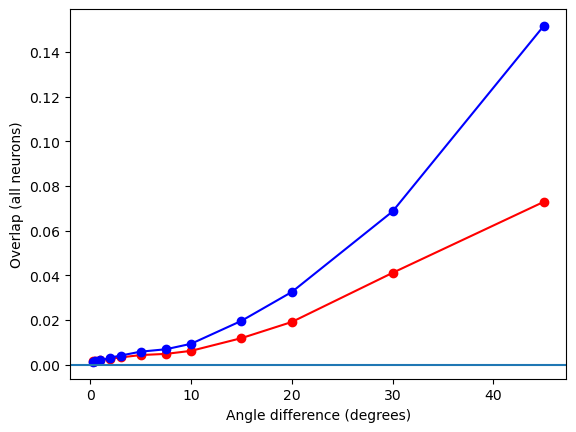

In [26]:
rawf = np.nanmean(fr_raw, axis=(0))
rawc = np.nanmean(ctr_raw, axis=(0))
plt.plot(360/np.array(conditions_saved), rawf, color='red', marker='o', linestyle='-', label='FR')
plt.plot(360/np.array(conditions_saved), rawc, color='blue', marker='o', linestyle='-', label='Control')
plt.xlabel('Angle difference (degrees)')
plt.ylabel('Overlap (all neurons)')
plt.axhline(0)

In [28]:
number_neurons = []
for i in range(14):
    x =remove_neurons(SATED_DECONV, SATED_ANGLE, SATED_SF, i)
    number_neurons.append(x.shape[0])
MIN_NEURONS = min(number_neurons)
print(number_neurons, MIN_NEURONS)

[50, 71, 44, 33, 26, 13, 68, 43, 56, 23, 35, 137, 45, 35] 13


Text(0, 0.5, 'Performance ')

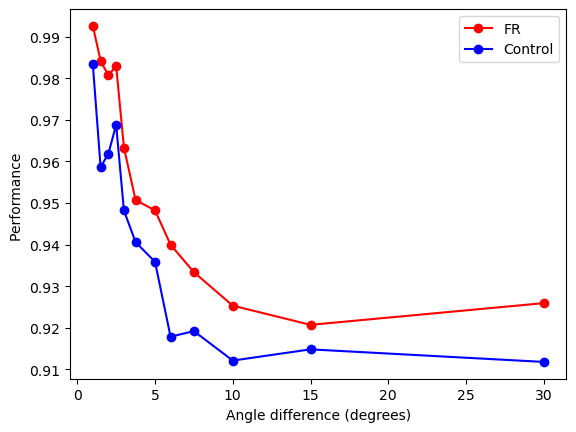

In [11]:
#FOR BEST SFS remove_new !!
####
####
####
# conditions_array = [8, 12, 18, 24, 36, 45, 48,60, 72, 120, 180, 360, 720, 1440]
# conditions_saved = [8, 12, 18, 24, 36, 45, 48, 60, 72, 120, 180, 360, 720]
# folder_name = "saved_overlap_eigs_normal_2509_smaller_sf_sum_remove_new"
# fr_raw =  np.full((8,len(conditions_saved)),np.nan)
# ctr_raw =  np.full((8,len(conditions_saved)),np.nan)
sum_snr_value_fr = np.full((8,len(conditions_saved)),np.nan)
for animal_number in range(1,9):
    try:
        data = load_overlap_eigs(folder_name, "FR", f"{animal_number}", sf=None)
        sum_snr_value_fr[animal_number-1,:] = data["snr_per_condition"]

    except Exception as e:
        continue


sum_snr_value_ctr = np.full((6,len(conditions_saved)),np.nan)
for animal_number in range(1,7):
    try:
        data = load_overlap_eigs(folder_name, "CTR", f"{animal_number}", sf=None)
        sum_snr_value_ctr[animal_number-1,:] = data["snr_per_condition"]

    except Exception as e:
        continue

snr_fr = np.nanmean(sum_snr_value_fr, axis=(0))
snr_ctr = np.nanmean(sum_snr_value_ctr, axis=(0))
performance_fr = stats.norm.cdf(np.sqrt(snr_fr)/2)
performance_ctr = stats.norm.cdf(np.sqrt(snr_ctr)/2)

# print(conditions_saved.shape, sum_snr_value_fr.shape, sum_snr_value_ctr.shape)
plt.figure()
plt.plot(360/np.array(conditions_saved), performance_fr, color='red', marker='o', linestyle='-', label='FR')
plt.plot(360/np.array(conditions_saved), performance_ctr, color='blue', marker='o', linestyle='-', label='Control')
plt.legend()
plt.xlabel('Angle difference (degrees)')
plt.ylabel('Performance ')
# plt.xlim(0,40)

In [ ]:
snr_all = np.zeros((num_repeats, 12))
for r in range(num_repeats):
    with numpyro.handlers.seed(rng_seed=inference_seed + 1000*r):
        mu_hat, sigma_hat, F_hat = posterior.sample(X_CONDITIONS_ALL)

    # Sample & compute per requested condition grid
    for idx, condition_number in enumerate(array_conditions):
        X_TEST_CONDITIONS = jnp.linspace(0, C - 1, condition_number)
        with numpyro.handlers.seed(rng_seed=inference_seed + 1000*r + 10*idx):
            mu_test_hat, sigma_test_hat, F_test_hat = posterior.sample(X_TEST_CONDITIONS)
        
        for og_conds in range(12):
            eigvals, eigvecs = np.linalg.eigh(sigma_hat[og_conds,:,:])

            # find Delta Mu for each og_cond
            number_angles,number_evals = mu_test_hat.shape
            equivalent_cond = int((og_conds * condition_number) // C)
            d_mu1 = mu_hat[r,:] - mu_test_hat[(equivalent_cond+1)%number_angles,:]
            d_mu2 = mu_hat[r,:] - mu_test_hat[(equivalent_cond-1)%number_angles,:]
            d_mu = d_mu1 if np.linalg.norm(d_mu1) < np.linalg.norm(d_mu2) else d_mu2        # choose signal vector with the smallest norm
            overlap_per_angle = np.zeros((number_evals))
            for evallss in range(number_evals):
                overlap_per_angle[evallss] = np.power((np.dot(d_mu, eigvecs[:,evallss])),2)
            snr_angle = np.nansum(overlap_per_angle/eigvals)
            snr_all[r,idx] += (float(snr_angle))
        snr_all[r,idx] /= 12
        # SNR_OUTPUTS[idx] = snr_average
snr_per_condition = np.nanmean(snr_all, axis=0)

In [20]:
rng = np.random.default_rng(2)

idx_random = rng.choice(100, 50, replace=False)
print(idx_random.shape)

(50,)
